In [2]:
import glob
import os
import string

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import matplotlib.ticker as ticker

from sklearn.metrics import confusion_matrix

In [3]:
!unzip data.zip

Archive:  data.zip
   creating: data/
  inflating: data/.DS_Store          
  inflating: data/eng-fra.txt        
   creating: data/names/
   creating: data/names/.ipynb_checkpoints/
  inflating: data/names/.ipynb_checkpoints/English-checkpoint.txt  
  inflating: data/names/.ipynb_checkpoints/French-checkpoint.txt  
  inflating: data/names/.ipynb_checkpoints/German-checkpoint.txt  
  inflating: data/names/Arabic.txt   
  inflating: data/names/Chinese.txt  
  inflating: data/names/Czech.txt    
  inflating: data/names/Dutch.txt    
  inflating: data/names/English.txt  
  inflating: data/names/French.txt   
  inflating: data/names/German.txt   
  inflating: data/names/Greek.txt    
  inflating: data/names/Irish.txt    
  inflating: data/names/Italian.txt  
  inflating: data/names/Japanese.txt  
  inflating: data/names/Korean.txt   
  inflating: data/names/Polish.txt   
  inflating: data/names/Portuguese.txt  
  inflating: data/names/Russian.txt  
  inflating: data/names/Scottish.txt  
  

### Load Data

The names can be found in text files in a src directory, one file per language.

In the following you can find some utilities to load the data into pandas data frames. 

We will restrict to some common European languages. 

With the given selection, we will identify all the occurring characters and initialize an alphabet.<br>
For this alphabet, we will use a one-hot-encoding to map them into a vector space representation. 

Foresee a suitable character for the end of the word, e.g. 'END'.

In [4]:
srcdir = 'data/names'
languages = ["English","French","Italian","German","Spanish"]

In [5]:
# inspect the data directory
def findFiles(path): 
    return glob.glob(path)

In [6]:
print('\n'.join(findFiles(os.path.join(srcdir,'*.txt'))))

data/names/Japanese.txt
data/names/Czech.txt
data/names/Greek.txt
data/names/French.txt
data/names/Arabic.txt
data/names/Italian.txt
data/names/German.txt
data/names/Dutch.txt
data/names/Vietnamese.txt
data/names/Russian.txt
data/names/Chinese.txt
data/names/Scottish.txt
data/names/Portuguese.txt
data/names/Irish.txt
data/names/Spanish.txt
data/names/Korean.txt
data/names/Polish.txt
data/names/English.txt


In [7]:
# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return lines

def load_data(srcdir, categories=None):
    names_list = []
    for filename in findFiles(os.path.join(srcdir,'*.txt')):
        category = os.path.splitext(os.path.basename(filename))[0]
        if not categories or category in categories: 
            names = readLines(filename)
            names_list.extend([(name,category) for name in names])
    df = pd.DataFrame(names_list)
    df.columns = ["name","lang"]
    return df

In [8]:
names = load_data(srcdir,categories=languages)
names.head()

,name,lang
0,Abel,French
1,Abraham,French
2,Adam,French
3,Albert,French
4,Allard,French


In [9]:
maxlen = np.max([len(name) for name in names.name])
print("Maximum name length: ", maxlen)

Maximum name length:  18


In [10]:
alphabet = sorted(list(set(''.join([name for name in names.name]))))
alphabet.append('END')
len_alphabet = len(alphabet)
char_index = dict((c, i) for i, c in enumerate(alphabet))
print("Size of alphabet: ",len_alphabet)
print(alphabet)

Size of alphabet:  74
[' ', "'", 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'Á', 'É', 'ß', 'à', 'á', 'ä', 'ç', 'è', 'é', 'ê', 'ì', 'í', 'ñ', 'ò', 'ó', 'ö', 'ù', 'ú', 'ü', 'END']


In [11]:
names.groupby('lang')['name'].count()/len(names)

lang
English    0.646230
French     0.048802
German     0.127555
Italian    0.124912
Spanish    0.052502
Name: name, dtype: float64

### Vector Representations

Now construct the vector representation by using one-hot-vectors. 

In [12]:
language_to_index = {country:index for index,country in enumerate(names.lang.unique())}
index_to_language = {index:country for index,country in enumerate(names.lang.unique())}

def onehot(i, length):
    v = np.zeros(length);
    v[i] = 1
    return v

def name_representation(name, maxlen):
    ### START YOUR CODE
    name_trunc = str(name)[0:maxlen]
    size = len(char_index)
    vector = [onehot(char_index[j], size) for j in str(name)]
    # fill the rest with 
    for k in range(0,maxlen - len(str(name))):
        vector.append(onehot(char_index['END'], size))
    return vector
    ### START YOUR CODE

def lang_representation(language, language_to_index):
    y = np.zeros(len(language_to_index))
    y[language_to_index[language]]=1
    return y

def lang_from_output(score):
    return index_to_language[np.argmax(score)]

def predict(name, model):
    score = model.predict(np.array([name_representation(name, maxlen)]))[0]
    return lang_from_output(score)

### Prepare train/test

Split the data into train/test

Shuffle the data

Transform the names data into a suitable vector respresentation:
* names into numpy arrays of shape (*,maxlen,len_alphabet)
* language into numpy array of shape (*,len(languages))



In [120]:
test_split = 0.2

### START YOUR CODE
# Shuffle and split names data

from sklearn.model_selection import train_test_split


train, test = train_test_split(names, test_size=test_split)

### END YOUR CODE

In [121]:
### START YOUR CODE

# Map train and test data into vector space (one-hot-vectors)

X_train = np.array([name_representation(i, maxlen) for i in train['name']])
Y_train = np.array([lang_representation(i, language_to_index) for i in train['lang']])

X_test = np.array([name_representation(i, maxlen) for i in test['name']])
Y_test =np.array([lang_representation(i, language_to_index) for i in test['lang']])
### END YOUR CODE

### Utilities

In [68]:
def performance_plots(model, X_test, Y_test, log, epochs):    
    acc = log.history['accuracy']
    val_acc = log.history['val_accuracy']
    print('Train accuracy (end):', acc[-1])
    print('Train accuracy (max):', np.max(acc))
    print('Test accuracy (end) :', val_acc[-1])
    print('Test accuracy (max) :', np.max(val_acc))

    plt.plot(log.history['accuracy'])
    plt.plot(log.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc='upper left')
    plt.axis([0,epochs,0.0,1.0])
    plt.show()

    plt.plot(log.history['loss'])
    plt.plot(log.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc = 'upper left')
    plt.axis([0,epochs,0.0,2.0])
    plt.show()

In [70]:
import sklearn
import pandas as pd

def confusion_matrix(model, X_test, Y_test):
    scores = model.predict(X_test)
    predictions = np.argmax(scores, axis=1)
    labels = np.argmax(Y_test, axis=1)
    nsamples = Y_test.shape[0]
    cm = sklearn.metrics.confusion_matrix(labels, predictions)
    df = pd.DataFrame({languages[i] : cm[:,i] for i in range(len(languages))}, languages)
    return df, cm

### Define and Train Model: Single Layer with SimpleRNN

Create an RNN consisting of a single layer with a SimpleRNN (keras) and a softmax.

Then train the model. Play with different number of hidden units in the layer to obtain a good accuracy.

In [122]:
### START YOUR CODE
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense

# SImpleRNN, single layer with tf.keras....

model = Sequential()
model.add(SimpleRNN(units=64, input_shape=(maxlen, len_alphabet), activation='tanh'))
model.add(Dense(len(languages), activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

### END YOUR CODE

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_28 (SimpleRNN)    (None, 64)                8896      
_________________________________________________________________
dense_18 (Dense)             (None, 5)                 325       
Total params: 9,221
Trainable params: 9,221
Non-trainable params: 0
_________________________________________________________________


In [123]:
### START YOUR CODE
batch_size= 64
nepochs = 50

log = model.fit(X_train, Y_train, batch_size=batch_size, epochs=nepochs, validation_data=(X_test, Y_test))

### END YOUR CODE

Epoch 1/50
71/71 [==============================] - 2s 14ms/step - loss: 1.1384 - accuracy: 0.6407 - val_loss: 0.9692 - val_accuracy: 0.6708
Epoch 2/50
71/71 [==============================] - 1s 7ms/step - loss: 0.9149 - accuracy: 0.6768 - val_loss: 0.8520 - val_accuracy: 0.7139
Epoch 3/50
71/71 [==============================] - 1s 7ms/step - loss: 0.8021 - accuracy: 0.7219 - val_loss: 0.7552 - val_accuracy: 0.7386
Epoch 4/50
71/71 [==============================] - 0s 7ms/step - loss: 0.7309 - accuracy: 0.7371 - val_loss: 0.7278 - val_accuracy: 0.7553
Epoch 5/50
71/71 [==============================] - 1s 7ms/step - loss: 0.7011 - accuracy: 0.7514 - val_loss: 0.7661 - val_accuracy: 0.7306
Epoch 6/50
71/71 [==============================] - 0s 7ms/step - loss: 0.6653 - accuracy: 0.7583 - val_loss: 0.7292 - val_accuracy: 0.7526
Epoch 7/50
71/71 [==============================] - 1s 7ms/step - loss: 0.6575 - accuracy: 0.7689 - val_loss: 0.6852 - val_accuracy: 0.7641
Epoch 8/50
71/71 [=

Train accuracy (end): 0.9488986730575562
Train accuracy (max): 0.9488986730575562
Test accuracy (end) : 0.7411971688270569
Test accuracy (max) : 0.7737675905227661


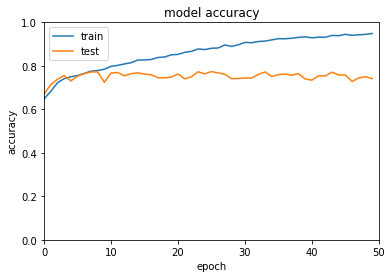

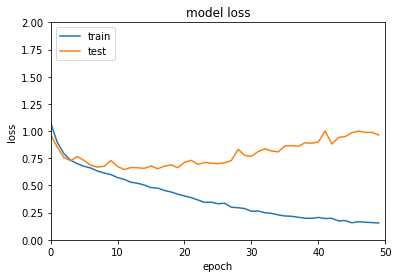

,English,French,Italian,German,Spanish
English,19,6,10,7,30
French,5,104,3,14,16
Italian,4,4,67,3,49
German,2,20,3,12,18
Spanish,19,21,48,12,640


In [124]:
performance_plots(model, X_test, Y_test, log, nepochs)
df, cm = confusion_matrix(model, X_test, Y_test)
df

#### Findings
We see that the model overfits and that the test loss does not decrease but increases.We also see that the classes are unbalanced. 

Accuracy : 
* Number of unit=32: 0.7121
* Number of unit=64: 0.7411

The model with more units gives better performance

### Handle Class Imbalance, Resampling

We can observe a quite significant class imbalance in the data.<br>

One way to compensate for that would be to use resampling.

In [95]:
def handle_imbalance(names, languages):
    ### START YOUR CODE
    max_class = names.groupby('lang')['name'].count().max()

    # treat class imbalance
    names_upsampled = pd.DataFrame(columns=['name', 'lang'])
    for l in languages:
      sub_df = names[names['lang'] == l].sample(max_class, replace=True)
      names_upsampled = pd.concat([names_upsampled, sub_df])

    ### END YOUR CODE    
    return names_upsampled


In [132]:
names_upsampled = handle_imbalance(names, languages)
names_upsampled.groupby('lang')['name'].count()/len(names_upsampled)

lang
English    0.2
French     0.2
German     0.2
Italian    0.2
Spanish    0.2
Name: name, dtype: float64

#### Train Model

Again prepare train and test data (X_train, X_test, Y_train, Y_test)

Train the same model as above with the new data.

In [133]:
### START YOUR CODE

train, test = train_test_split(names, test_size=test_split)

X_train = np.array([name_representation(i, maxlen) for i in train['name']])
Y_train = np.array([lang_representation(i, language_to_index) for i in train['lang']])

X_test = np.array([name_representation(i, maxlen) for i in test['name']])
Y_test =np.array([lang_representation(i, language_to_index) for i in test['lang']])

### END YOUR CODE

In [138]:
### START YOUR CODE

# train model

model = Sequential()
model.add(SimpleRNN(units=32, input_shape=(maxlen, len_alphabet), activation='tanh'))
model.add(Dense(len(languages), activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

batch_size= 64
nepochs = 30

log = model.fit(X_train, Y_train, batch_size=batch_size, epochs=nepochs, validation_data=(X_test, Y_test))

### END YOUR CODE

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_35 (SimpleRNN)    (None, 32)                3424      
_________________________________________________________________
dense_25 (Dense)             (None, 5)                 165       
Total params: 3,589
Trainable params: 3,589
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
71/71 [==============================] - 2s 14ms/step - loss: 1.2985 - accuracy: 0.5092 - val_loss: 1.0654 - val_accuracy: 0.6523
Epoch 2/30
71/71 [==============================] - 0s 6ms/step - loss: 1.0397 - accuracy: 0.6463 - val_loss: 0.9412 - val_accuracy: 0.6893
Epoch 3/30
71/71 [==============================] - 0s 6ms/step - loss: 0.9324 - accuracy: 0.6723 - val_loss: 0.8517 - val_accuracy: 0.7148
Epoch 4/30
71/71 [==============================] - 0s 6ms/step - loss: 0.8118 - accuracy: 0

Train accuracy (end): 0.8240088224411011
Train accuracy (max): 0.8284140825271606
Test accuracy (end) : 0.7684859037399292
Test accuracy (max) : 0.7711267471313477


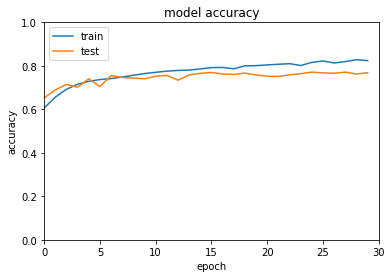

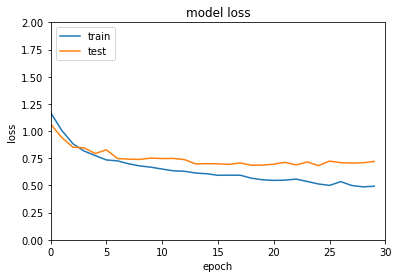

,English,French,Italian,German,Spanish
English,4,4,1,3,43
French,3,112,2,11,28
Italian,1,3,49,0,75
German,1,15,4,11,26
Spanish,5,13,23,2,697


In [139]:
performance_plots(model, X_test, Y_test, log, nepochs)
df, cm = confusion_matrix(model, X_test, Y_test)
df

#### Findings
We can see that this time if the model overfits less and gives better performance. On constate également une amélioration de l'accuracy.
We can see that this time if the model overfits less and gives better performance. On constate également une amélioration de l'accuracy.



#### In which situations is class imbalance treatment important and why?  

The treatment of unbalanced classes is important in case of overfitting.

It is also important to see if in production the classes will be balanced or not. In our case we want the model to give the same importance to each language. So we have to resample the dataset

### Implement Model with several SimpleRNN Layers

In [149]:
### START YOUR CODE

model = Sequential()
model.add(SimpleRNN(units=64, input_shape=(maxlen, len_alphabet), return_sequences=True))
model.add(SimpleRNN(units=64, return_sequences=True))
model.add(SimpleRNN(units=32, return_sequences=False))
model.add(Dense(len(languages), activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### END YOUR CODE

model.summary()

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_45 (SimpleRNN)    (None, 18, 64)            8896      
_________________________________________________________________
simple_rnn_46 (SimpleRNN)    (None, 18, 64)            8256      
_________________________________________________________________
simple_rnn_47 (SimpleRNN)    (None, 32)                3104      
_________________________________________________________________
dense_29 (Dense)             (None, 5)                 165       
Total params: 20,421
Trainable params: 20,421
Non-trainable params: 0
_________________________________________________________________


In [150]:
### START YOUR CODE

batch_size= 64
nepochs = 30

log = model.fit(X_train, Y_train, batch_size=batch_size, epochs=nepochs, validation_data=(X_test, Y_test))

### END YOUR CODE

Epoch 1/30
71/71 [==============================] - 6s 33ms/step - loss: 1.1389 - accuracy: 0.6114 - val_loss: 0.9653 - val_accuracy: 0.6681
Epoch 2/30
71/71 [==============================] - 1s 17ms/step - loss: 0.8898 - accuracy: 0.6943 - val_loss: 0.7995 - val_accuracy: 0.7403
Epoch 3/30
71/71 [==============================] - 1s 17ms/step - loss: 0.7366 - accuracy: 0.7407 - val_loss: 0.7564 - val_accuracy: 0.7500
Epoch 4/30
71/71 [==============================] - 1s 17ms/step - loss: 0.6280 - accuracy: 0.7834 - val_loss: 0.7095 - val_accuracy: 0.7694
Epoch 5/30
71/71 [==============================] - 1s 17ms/step - loss: 0.6012 - accuracy: 0.7893 - val_loss: 0.6729 - val_accuracy: 0.7826
Epoch 6/30
71/71 [==============================] - 1s 17ms/step - loss: 0.5573 - accuracy: 0.7987 - val_loss: 0.7651 - val_accuracy: 0.7306
Epoch 7/30
71/71 [==============================] - 1s 17ms/step - loss: 0.5473 - accuracy: 0.8069 - val_loss: 0.7312 - val_accuracy: 0.7394
Epoch 8/30
71

Train accuracy (end): 0.9447136521339417
Train accuracy (max): 0.949118971824646
Test accuracy (end) : 0.7579225301742554
Test accuracy (max) : 0.7852112650871277


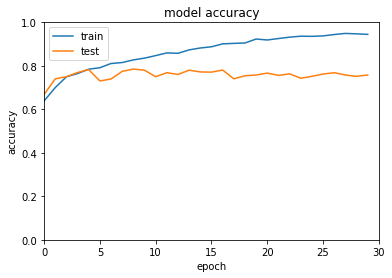

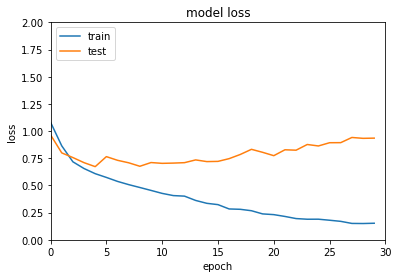

,English,French,Italian,German,Spanish
English,8,10,4,1,32
French,5,116,3,12,20
Italian,3,4,65,1,55
German,2,16,4,17,18
Spanish,17,18,44,6,655


In [151]:
performance_plots(model, X_test, Y_test, log, nepochs)
df, cm = confusion_matrix(model, X_test, Y_test)
df

#### Findings

List of experiences: 
* RNN(32), RNN(16), RNN(16), DENSE, B=64, E=30 -> Accuracy = 0.7420
* RNN(32), RNN(16), RNN(16), DENSE, B=128, E=30 -> Accuracy = 0.7323
* RNN(64), RNN(32), RNN(16), DENSE, B=128, E=30 -> Accuracy = 0.7772
* RNN(64), RNN(64), RNN(32), DENSE, B=64, E=30 -> Accuracy = 0.7579

We can see that on average the models have better performances than before. The best accuracy obtained is 0.7772.